In [1]:
import sys
sys.path.insert(0, '../..')
import os
import cv2
import numpy as np
import pandas as pd
import nibabel as nib
from skimage import transform
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from homologous_point_prediction.pipeline_components.point_placement import compute_points, filter_points
from mri_histology_toolkit.data_loader import load_histology, load_mri
from seaborn import heatmap
from mri_histology_toolkit.register import compare_pipelines, analyze_pipeline_qualitative, HumanControlPointPipeline, plot_dice, plot_point_deviation
from homologous_point_prediction.data_processing.helpers import reverse_center_prostate, center_prostate, pad_points
from homologous_point_prediction.standard_pipeline import HomologousPointPipeline
from prosregnet.standard_pipeline import ProsRegNetPipeline
from mri_histology_toolkit.data_loader import DataLoader
from mri_histology_toolkit.image import make_overlay
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import torch
import os
from homologous_point_prediction.models.helpers import load_model
from tensorflow.keras import Model

In [2]:
#pip uninstall -y mri_histology_toolkit

In [3]:
#pip uninstall -y homologous_point_prediction

In [4]:
#pip install git+ssh://git@gitlab.com/mcw_laviolette_lab/mri_histology_toolkit.git

In [5]:
config_path = os.path.abspath("/home/ruchtia/git/method_analysis/configs/test_config.json")
data_loader = DataLoader(config_path=config_path)

In [6]:
base_h_model_path = "/home/ruchtia/git/homologous_point_prediction/homologous_point_prediction/outputs/"
saved_h_model_name = "05-20-22|22:36:57/model"
mod_path = os.path.join(base_h_model_path, saved_h_model_name)

In [7]:
def get_dict(pat, slide, data_loader):
    for data_dict in data_loader:
        if str(pat) == data_dict["patient"] and str(slide) == data_dict["slide"]:
            return data_dict

# Zero

In [8]:
selected_patient = get_dict(1142, 8, data_loader)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [9]:
def plot_dice(fig, warped_img, mri_img, cs=0):
    '''
    Plot the dice coefficient of images

    @param fig: The figure to plot on
    @param warped_img: The warped masked histology image
    @param mri_img: The masked mri image
    @param cs: The number of pixels to crop from each edge of the image
    '''
    if cs > 0:
        warped_img = warped_img[cs:-cs, cs:-cs, :] if len(warped_img.shape) == 3 else warped_img[cs:-cs, cs:-cs]
        mri_img = mri_img[cs:-cs, cs:-cs, :] if len(mri_img.shape) == 3 else mri_img[cs:-cs, cs:-cs]
    
    if len(warped_img.shape) == 3:
        warped_img = np.sum(warped_img, axis=-1)
        warped_img = warped_img.reshape((512, 512))
        
    if len(mri_img.shape) == 3:
        mri_img = np.sum(mri_img, axis=-1)
        mri_img = mri_img.reshape((512, 512))
        
    warped_mask = warped_img > 0
    mri_mask = mri_img > 0
    overlap = (warped_mask & mri_mask)
    img = (np.stack((warped_mask, overlap, mri_mask), axis=-1) * 255).astype(int)
    fig.imshow(img)

In [10]:
base_prn_model_path = "/home/ruchtia/git/prosregnet/prosregnet/trained_models/"
affine_model_name = "best_affine.pth.tar"
tps_model_name = "best_tps.pth.tar"
affine_model_path = os.path.join(base_prn_model_path, affine_model_name)
tps_model_path = os.path.join(base_prn_model_path, tps_model_name)


prosregnet_pipeline = ProsRegNetPipeline(affine_model=affine_model_path, tps_model=tps_model_path)
prosregnet_pipeline.set_name("prosregnet - paper")

affine_model_name = "best_affine_mcw_tune.pth.tar"
tps_model_name = "best_tps_mcw_tune.pth.tar"
affine_model_path = os.path.join(base_prn_model_path, affine_model_name)
tps_model_path = os.path.join(base_prn_model_path, tps_model_name)


prosregnet_tuned_pipeline = ProsRegNetPipeline(affine_model=affine_model_path, tps_model=tps_model_path)
prosregnet_tuned_pipeline.set_name("prosregnet - tuned")
human_pipeline = HumanControlPointPipeline()
homologous_pipeline = HomologousPointPipeline(mod_path, requires_scaling=True)

In [11]:
#selected_pipeline = homologous_pipeline
selected_pipeline = human_pipeline
#selected_pipeline = prosregnet_pipeline
#selected_pipeline = prosregnet_tuned_pipeline

In [12]:
selected_pipeline.fit(selected_patient)

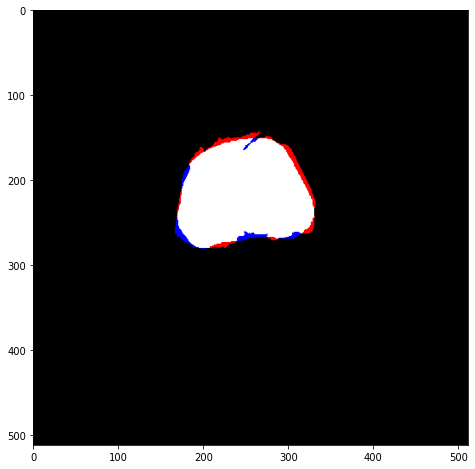

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
plot_dice(axs, selected_pipeline.warp_surface(selected_patient["rgb_hist"]), selected_patient["masked_mri"])
fig.savefig(selected_pipeline.model_name + "_dice.png")

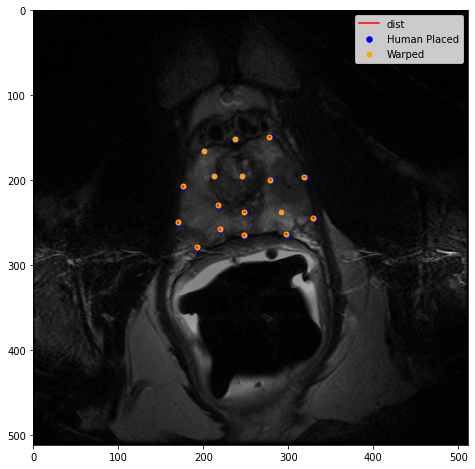

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
plot_point_deviation(axs, selected_patient["unmasked_mri"], selected_patient["mri_points"], selected_pipeline.warp_points(selected_patient["hist_points"]), cs=0)
fig.savefig(selected_pipeline.model_name + "_controlpoints.png")

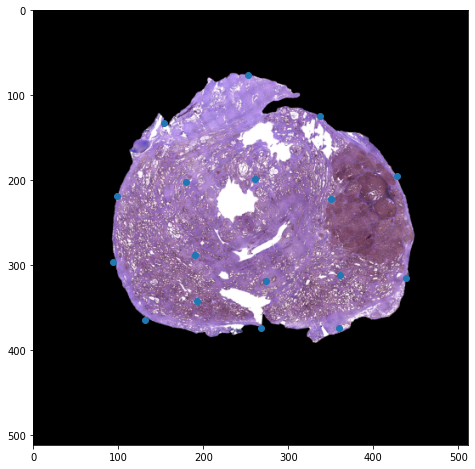

In [15]:
plt.figure(figsize=(8, 8))
plt.imshow(selected_patient["rgb_hist"])
plt.scatter(selected_pipeline.start_points[:, 1], selected_pipeline.start_points[:, 0])

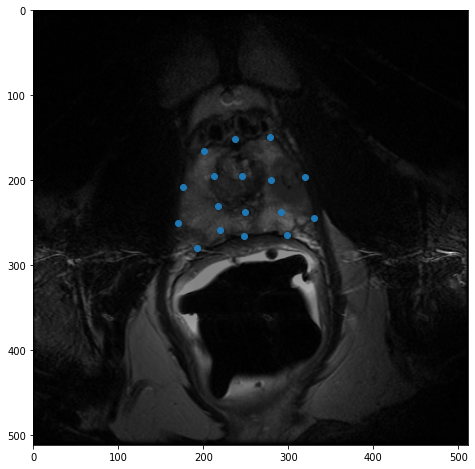

In [16]:
plt.figure(figsize=(8, 8))
plt.imshow(selected_patient["unmasked_mri"], cmap="gray")
plt.scatter(selected_pipeline.end_points[:, 1], selected_pipeline.end_points[:, 0])

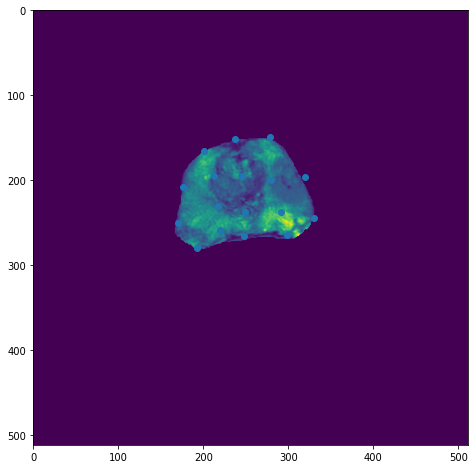

In [17]:
plt.figure(figsize=(8, 8))
plt.imshow(selected_patient["masked_mri"])
plt.scatter(selected_patient["mri_points"][:, 1], selected_patient["mri_points"][:, 0])

# One

In [18]:
m = load_model(mod_path)
heatmap_model = Model(m.input, m.get_layer("attention").output)

Loading Model:  OVERLAY_TRANSFORMER
Tensor("gather/Identity_1:0", shape=(None, 75, 2), dtype=float32)


In [19]:
slide = data_loader[24]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [29]:
fixed_image, input_points, _ = center_prostate(slide["grayscale_hist"], slide["hist_points"], other=None, padding=50)
_, mri_pts, moving_image = center_prostate(slide["unmasked_mri"], slide["mri_points"], other=slide["unmasked_mri"], padding=50)

In [21]:
num_points=75
points = input_points
heatmap_result = heatmap_model.predict([fixed_image.reshape((1,512,512,1)), moving_image.reshape((1,512,512,1)), pad_points(points, num_points).reshape(1, num_points, 2), np.zeros((1,1), dtype=np.int32), np.ones((1,1), dtype=np.int32)])
predicted_points = m.predict([fixed_image.reshape((1,512,512,1)), moving_image.reshape((1,512,512,1)), pad_points(points, num_points).reshape(1, num_points, 2), np.zeros((1,1), dtype=np.int32), np.ones((1,1), dtype=np.int32)]).reshape((-1, 2))[:len(points)]

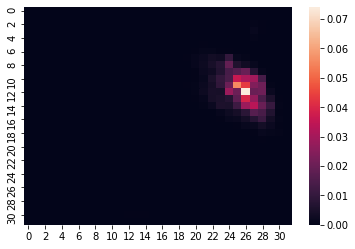

In [36]:
i = 5
heatmap(heatmap_result[0, i, :].reshape((32, 32)))
plt.scatter([predicted_points[i, 1]], [predicted_points[i, 0]])
plt.show()

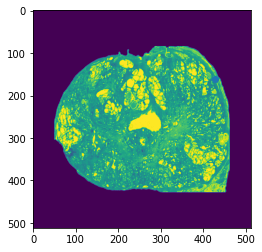

In [32]:
plt.imshow(fixed_image)
plt.scatter([input_points[i, 1]], [input_points[i, 0]])

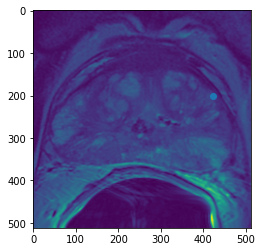

In [33]:
plt.imshow(moving_image)
plt.scatter([mri_pts[i, 1]], [mri_pts[i, 0]])

In [ ]:
plt.scatter([0,512], [0,])

# Two

In [ ]:
slide_dir = "/data/ur/bukowy/LaViolette_Data/Prostates/1122/7/"
slide_path = os.path.join(slide_dir, "small_recon_8_pgt_sharp.tiff" )

In [ ]:
mri = os.path.join(slide_dir, "mri_slice_double_T2_norm.nii")
mri = load_mri(mri)

In [ ]:
hist = cv2.imread(slide_path)
grayscale_hist = load_histology(slide_path)

In [ ]:
plt.imshow(grayscale_hist)

In [ ]:
fig = plt.figure(figsize=(16, 16))
for i in range(32**2):
    ax = plt.subplot(32, 32, i+1)
    y_offset = (i//(512//16)) * 16
    x_offset = (i%(512//16)) * 16
    plt.imshow(grayscale_hist[y_offset:y_offset+16, x_offset:x_offset+16], cmap="gray", vmin=0, vmax=1)
    plt.axis("off")

In [ ]:
fig.savefig("histology_patches.png")

### SIFT Point Density Functions

In [ ]:
points25 = np.array(compute_points(grayscale_hist * 255))

In [ ]:
points75 = np.array(compute_points(grayscale_hist * 255, dist_thresh=35))

In [ ]:
plt.imshow(hist)
plt.scatter(points25[:, 1], points25[:, 0])
#plt.savefig("25_dist_thresh.png")

In [ ]:
plt.imshow(hist )
plt.scatter(points75[:, 1], points75[:, 0])
#plt.savefig("50_dist_thresh.png")

## Sift vs grid vs Human

In [ ]:
slide_dir = "/data/ur/bukowy/LaViolette_Data/Prostates/1122/7/"
slide_path = os.path.join(slide_dir, "small_recon_8_pgt_sharp.tiff" )
hist = cv2.imread(slide_path)
grayscale_hist = load_histology(slide_path)
human_placed = np.load("/home/ruchtia/git/homologous_point_prediction/homologous_point_prediction/multipoint_data_pruned/1122/7/fixed_hist_points.npy")

In [ ]:
def make_grid():
    x = np.linspace(0, 512, 512//35 + 1)
    y = np.linspace(0, 512,  512//35 + 1)
    xv, yv = np.meshgrid(x, y)
    return np.concatenate((yv.reshape((-1, 1)), xv.reshape(-1, 1)), axis=-1)

In [ ]:
sift_points = np.array(compute_points(grayscale_hist * 255, dist_thresh=35))
grid_points = filter_points(make_grid(), hist)
human_points = human_placed

In [ ]:
plt.imshow(hist)
plt.scatter(human_placed[:, 1], human_placed[:, 0])
plt.savefig("human_points_35_11227.png")

In [ ]:
plt.imshow(data_loader[2]["rgb_hist"])
plt.scatter(homologous_pipeline.start_points[:, 1], homologous_pipeline.start_points[:, 0], cmap=cm.jet, c=list(range(len(homologous_pipeline.start_points))))
plt.savefig("hist_withpoints.png")

In [ ]:
plt.imshow(data_loader[2]["unmasked_mri"], cmap="gray")
plt.scatter(homologous_pipeline.end_points[:, 1],homologous_pipeline.end_points[:, 0],  s=5, cmap=cm.jet, c=list(range(len(homologous_pipeline.start_points))))
plt.savefig("mr_with_points.png")

# Color Predicted Points

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(slide["grayscale_hist"], cmap='gray')
plt.scatter(homologous_pipeline.start_points[:, 1], homologous_pipeline.start_points[:, 0],  c=range(len( homologous_pipeline.end_points)), cmap=cm.jet)

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(slide["unmasked_mri"], cmap="gray")
plt.scatter(homologous_pipeline.end_points[:, 1], homologous_pipeline.end_points[:, 0], s=30, c=range(len( homologous_pipeline.end_points)), cmap=cm.jet)